# Beauty Detection Fasiai


In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
from fastkaggle import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set up

In [ ]:
comp = ''
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
display(path)

OSError: ignored

In [ ]:
from fastai.vision.all import *
set_seed(42)
path.ls()

(#7) [Path('../input/beauty-detection-data-set/class_dict.csv'),Path('../input/beauty-detection-data-set/EfficientNetB1-beauty-100.0.h5'),Path('../input/beauty-detection-data-set/beauty.csv'),Path('../input/beauty-detection-data-set/images to predict'),Path('../input/beauty-detection-data-set/valid'),Path('../input/beauty-detection-data-set/test'),Path('../input/beauty-detection-data-set/train')]

# Show the data

In [ ]:
trn_path = path/'train'
files = get_image_files(trn_path)

(224, 224)


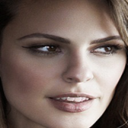

In [ ]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [ ]:
from fastcore.parallel import *
def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(224, 224)    4000
dtype: int64

# Train Data - ImageDataLoaders.from_folder

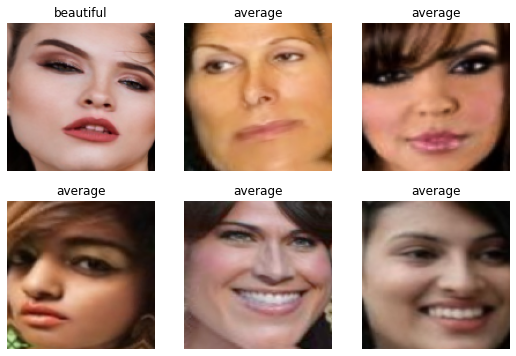

In [ ]:
#### train and valid folders separated
dls = ImageDataLoaders.from_folder(path, train='train', valid='valid', seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

#### train and valid data in train folder
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch(max_n=6)

# Model - resnet26d

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.0012022644514217973, slide=0.013182567432522774)

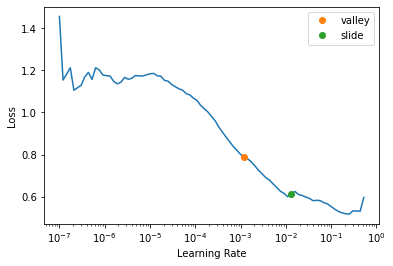

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,0.259478,0.072947,0.023333,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.142844,0.029095,0.016667,00:41
1,0.106893,0.037558,0.013333,00:39
2,0.083079,0.037314,0.016667,00:39


# Predict using Test Data

In [ ]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files)
print(tst_files[0:3])

[Path('../input/beauty-detection-data-set/test/average/001.jpg'), Path('../input/beauty-detection-data-set/test/average/002.jpg'), Path('../input/beauty-detection-data-set/test/average/003.jpg')]


In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [ ]:
print(idxs)
print(dls.vocab)

TensorBase([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
mapping = dict(enumerate(dls.vocab))
print(mapping)
reverse_mapping=dict(zip(dls.vocab,list(range(len(dls.vocab)))))
print(reverse_mapping)

{0: 'average', 1: 'beautiful'}
{'average': 0, 'beautiful': 1}


In [ ]:
results = pd.Series(idxs.numpy(),name="idxs").map(mapping)
display(results)

0        average
1        average
2        average
3        average
4        average
         ...    
295    beautiful
296    beautiful
297    beautiful
298    beautiful
299    beautiful
Name: idxs, Length: 300, dtype: object

In [ ]:
testY=[]
for item in tst_files:
    testY+=[reverse_mapping[item.parent.name]]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(testY,idxs,target_names=dls.vocab,digits=4))

              precision    recall  f1-score   support

     average     1.0000    0.9933    0.9967       150
   beautiful     0.9934    1.0000    0.9967       150

    accuracy                         0.9967       300
   macro avg     0.9967    0.9967    0.9967       300
weighted avg     0.9967    0.9967    0.9967       300

